<a href="https://colab.research.google.com/github/alexunderch/Bachelor_materials/blob/main/KG_course_ods/hws/KG2021RU_(CS224W_Colab_3)_(DONE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://habrastorage.org/webt/wm/bs/md/wmbsmdxsduiamoki0tpt8vgfvvq.png)

# Заимствовано с гордостью!
перевод публично доступных [материалов](https://colab.research.google.com/drive/1AjLbfuz9qXE5yglPOifUKhOHkzAuHmOF?usp=sharing#scrollTo=8gzsP50bF6Gb) курса [cs224w](http://web.stanford.edu/class/cs224w/)

# **CS224W - Colab 3**

В предыдущем блокнотике мы сконструировали графовую нейронную сеть с помощью встроенного в PyTorch Geometric слоя GCN - `GCNConv`. В этом блокнотике мы реализуем архитектуры **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)) и **GAT** ([Veličković et al. (2018)](https://arxiv.org/abs/1710.10903)). Затем скормим нашим сетям набор данных CORA, стандартный тест для сетей цитирования.

Затем воспользуемся [DeepSNAP](https://snap.stanford.edu/deepsnap/), библиотекой Python, помогающей эффективно обучать глубокие модели на графах в разнообразных условиях и применять трансформации к данным.

Наконец, с помощью функционала DeepSNAP для трансдуктивного разбиения рёбер, сконструируем простую графовую нейронную сеть для предсказания свойств рёбер(задача предсказания связей или link prediction).

**Обратите внимание**:  
Убедитесь в том, чтобы **последовательно запускать все ячейки с кодом в рамках каждой секции**, таким образом промежуточные переменные будут переданы в последующую ячейку.

Развлекайтесь с Colab 3 :)

# Устройство
Вам может потребоваться графический ускоритель для этого блокнота.

Пожалуйста выберите `Среда выполенения (Runtime)` и затем `Сменить среду выполенения (Change runtime type)`. Выберите **GPU** для `Аппаратный ускоритель (hardware accelerator)`.

# Установка

In [1]:
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
# !pip install -q torch-geometric
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 12.4 MB/s 
     |████████████████████████████████| 3.5 MB 43.7 MB/s 
     |████████████████████████████████| 2.5 MB 35.3 MB/s 
     |████████████████████████████████| 750 kB 40.6 MB/s 
     |████████████████████████████████| 407 kB 12.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=bfc1e92cbb4d45e4d9f7cbf2490f6d1aac74a27ecd647d81d04483c14f31b45c
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [2]:
import torch_geometric
torch_geometric.__version__

'2.0.4'

# 1 Слои GNN

## Реализация модулей слоёв

В colab 2 мы реализовали сеть, использовав GCN для задач классификации вершин и графов. Однако, сам модуль GCN - часть официальной библиотеки. Для данной задачи мы предоставим вам конструкцию общего назначения - Graph Neural Network Stack, в которую можно подключить ваши собственные модули GraphSAGE и GAT. Мы применим нашу реализацию к классификации вершин на стандартном наборе данных цитирования CORA. В этом наборе данных вершины соответствуют документам и рёбра отражают неориентированные цитаты. Каждой вершине назначена метка класса. Свойства вершины - представление содержимого в виде мешка слов (bag-or-words). В наборе данных CORA 2708 вершин, 5429 рёбер, 7 классов для вершин и 1433 признака на вершину.

## GNN Stack Module

Ниже представлена реализация обобщённого модуля графовой нейронной сети, в который можно подключать любые слои, включая **GraphSage**, **GAT**, и пр. Данный модуль предоставлен для вашего удобства и ваша реализация слоёв **GraphSage** и **GAT** будет работать как подключаемые компоненты в GNNStack Module.

In [3]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage': return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, one needs to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, you need to change the for-loop when builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label): return F.nll_loss(pred, label)

## GraphSage - реализация

Приступим к реализации слоёв! В данной части вы ознакомитесь с тем, как реализовать слой в PyTorch, основанный на передаче сообщений (Message Passing). Вы реализуете функции **forward**, **message** и **aggregate**.

В общем, функция **forward** - выполняет непосредственно передачу сообщений. Вся логика на каждой итерации происходит в **forward**, в которой вызывается функция **propagate** для передачи информации от соседей центральной вершине. Общая парадигма: pre-processing -> propagate -> post-processing.

Вспомните процесс передачи сообщений, рассмотренный в homework 1 (возможно, когда-то будет доступна широкой публике). Затем **propagate** вызывает функции **message**, которая трансформирует информацию от соседей в сообщения, **aggregate**, которая аггрегирует все сообщения от соседних вершин в одну, и  **update**, которая создаёт эмбеддинги вершин в следующей итерации.

Наша реализация несколько отличается от описанной и мы не будем явно реализовывать **update**, но вынесем логику обновления вершин в функцию **forward**. Более конкретно, после того, как информация передана, мы можем произвести некоторые операции на выходе из **propagate**. Выход **forward** - это эмбеддинги после текущей итерации.

Кроме того, тензоры, отправленные в **propagate()** можно сопоставить с вершинами $i$ и $j$, добавляя _i или _j к имени переменной, например, x_i и x_j. Обратите внимание, мы в общем случае обозначаем $i$ как центральные вершины, аггрегирующие информацию и $j$ - соседние вершины, следуя наиболее распространённой нотации.

Пожалуйста, обратитесь к комментариям для более подробных инструкций. Также стоит упомянуть, что мы добавим **skip connections** нашей GraphSage. Фомально, правило обновления примет следующий вид:

\begin{equation}
h_v^{(l)} = W_l\cdot h_v^{(l-1)} + W_r \cdot AGG(\{h_u^{(l-1)}, \forall u \in N(v) \})
\end{equation}

Для простоты мы используем аггрегацию усреднением (mean aggregations), где:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N(v) \}) = \frac{1}{|N(v)|} \sum_{u\in N(v)} h_u^{(l-1)}
\end{equation}

Кроме того, после каждой итерации мы применим $\ell$-2 нормализацию.

Для того, чтобы выполнить задание корректно, нам следует понимать как взаимодействуют между собой различные функции. В **propagate** мы можем отправить какие угодно параметры. Например, подадим на вход $x$:

... = propagate(..., $x$=($x_{central}$, $x_{neighbor}$), ...)

Здесь $x_{central}$ и $x_{neighbor}$ представляют собой свойства **цнтральных** вершин и **соседних** (или инцидентных им) вершин. Если мы будем использовать одинаковое представление от центральных и соседних вершин, тогда $x_{central}$ и $x_{neighbor}$ могут быть идентичны.

Предположим, $x_{central}$ и $x_{neighbor}$ одной размерности N * d, где N - количество вершин, а d - размерность вектора свойств вершины.

Тогда в функцию сообщений (message function) мы сможем принять параметры $x\_i$ и $x\_j$. Обыкновенно $x\_i$ обозначает "центральные вершины", а $x\_j$ - "соседние вершины". Обратите внимание на размерность: $x\_i$ и $x\_j$ - одинаковой размерности E * d (**не N!**). $x\_i$ получается конкатенацией эмбеддингов центральных вершин для всех рёбер через таблицу соответствия (lookup) из $x_{central}$ мы отправили в propagate. Подобным образом, $x\_j$ получается конкатенацией эмбеддингов соседних вершин всех рёбер сопоставлением из таблицы соответствия (lookup) $x_{neighbor}$, отправленных в propagate.

Рассмотрим пример. Пусть у нас 4 вершины, таким образом $x_{central}$ и $x_{neighbor}$ иеют размерность 4 * d. У нас два ребра (1, 2) и (3, 0). Таким образом, $x\_i$ получается как $[x_{central}[1]^T; x_{central}[3]^T]^T$, и $x\_j$ получается как $[x_{neighbor}[2]^T; x_{neighbor}[0]^T]^T$

<font color='red'>Для последующих вопросов НЕ используйте никакие из публично доступных вариантов реализации.</font>

In [4]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################################################################
        # ЗАДАЧА: Ваш код здесь!
        # Реализйте слои, необходимые для функций message и update. 
        # self.lin_l - это линейная трансформация, которую вы примените к эмбеддингам
        #              для центральной вершины.
        # self.lin_r - это линейная трансформация, которую вы примените к аггрегированным
        #              сообщениям от соседей.
        # Наша реализация ~2 строки кода, но не волнуйтесь, если ваша будет отличаться.
        self.lin_l = torch.nn.Linear(in_channels, out_channels, bias = bias)
        self.lin_r = torch.nn.Linear(in_channels, out_channels, bias = bias) #one dimension
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############################################################################
        # ЗАДАЧА: Ваш код здесь!
        # Реализуйте прохождение сообщений (message passing) и пост-процессинг (update).
        # 1. Сначала вызовите функцию propagate для передачи сообщений.
        #    1.1 Здесь вы найдёте более подробную информацию: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 Мы используем одинаковые представления для центральных (x_central) и 
        #        соседних (x_neighbor) вершин, это означает, что вы передадите x=(x, x) 
        #        в функцию propagate.
        # 2. Обновите эмбеддинги вершин вместе с skip connection.
        # 3. Если установлен параметр normalize, проведите L-2 нормализацию (определена в 
        #    torch.nn.functional)
        # Наша реализация ~5 строк кода, но не волнуйтесь, если ваша будет отличаться.

        out_message = self.propagate(edge_index, x = (x, x), size = size)
        out = self.lin_l(x) + self.lin_r(out_message)
        if self.normalize: out = F.normalize(out, p=2., dim=-1)
        
        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############################################################################
        # ЗАДАЧА: Ваш код здесь!
        # Реализуйте вашу функцию message здесь.
        # Наша реализация ~1 строка кода, но не волнуйтесь, если ваша будет отличаться.
        out = x_j

        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # Ось, по которой индексировать вершины / The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################################################################
        # ЗАДАЧА: Ваш код здесь! 
        # Реализуйте вашу функцию aggregate.
        # Подробнее о использовании torch_scatter.scatter: 
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        # Наша реализация ~1 строка кода, но не волнуйтесь, если ваша будет отличаться.
        out = torch_scatter.scatter(src = inputs, index = index, 
                                    dim = node_dim, dim_size = dim_size,
                                    reduce = 'mean')

        ############################################################################

        return out


## GAT - реализация

Механизмы внимания (attention) демонстрируют наилучшие (state-of-the-art) результаты во многих задачах, основанных на последовательностях, таких как машинный перевод или векторные представления предложений. Одно из основных преимуществ механизмов внимания - их способность сконцентрироваться на наиболее релевантных частях входной информации для принятия решения. В данной задаче мы посмотрим как использовать механизм внимания для классификации вершин графа с использованием графовых нейронных сетей с вниманием (Graph Attention Networks (GATs)).

Строительный блок графовой нейронной сети с вниманием - это слой графового внимания, который представляет собой вариант функции аггрегации. Пусть $N$ - количество вершин и $F$ - размерность вектора признаков для каждой вершины. Входом каждого слоя графового внимания является множество свойств вершин: $\mathbf{h} = \{\overrightarrow{h_1}, \overrightarrow{h_2}, \dots, \overrightarrow{h_N}$\}, $\overrightarrow{h_i} \in R^F$. Выходом каждого слоя графового внимания является новый набор свойств вершин, который может иметь новую размерность $F'$: $\mathbf{h'} = \{\overrightarrow{h_1'}, \overrightarrow{h_2'}, \dots, \overrightarrow{h_N'}\}$, with $\overrightarrow{h_i'} \in \mathbb{R}^{F'}$.

Теперь мы опишем эту трансформацию входных признаков в признаки более высокого уровня, производимые каждым слоем графового внимания. Сначала происходит общее для всех вершин линейное преобразование, параметризованное матрицей весов $\mathbf{W} \in \mathbb{R}^{F' \times F}$. Далее, запускается самосознание (self-attention) для вершин. Мы используем один на всех механизм внимания:
\begin{equation} 
a : \mathbb{R}^{F'} \times \mathbb{R}^{F'} \rightarrow \mathbb{R}.
\end{equation}

Этот механизм вычисляет коэффициенты внимания, которые отражают важность признаков вершины $j$ для вершины $i$:
\begin{equation}
e_{ij} = a(\mathbf{W_l}\overrightarrow{h_i}, \mathbf{W_r} \overrightarrow{h_j})
\end{equation}
Наиболее общая формулировка влияния позволяет каждой вершине влиять на все прочие, что исключает всю информацию о структурных связях. Для того, чтобы воспользоваться структурой графа в механизмах внимания, мы можем воспользоваться вниманием с маской (masked attention). Во вниманиии с маской мы вычисляем лишь $e_{ij}$ для вершин $j \in \mathcal{N}_i$, где $\mathcal{N}_i$  является каким-то окружением вершины $i$ в графе.

Для простоты сравнения коэффициентов между различными вершинами мы нормализуем коэффициенты между $j$ using с помощью функции softmax:
\begin{equation}
\alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}_i} \exp(e_{ik})}
\end{equation}

Для этой задачи наш механизм внимания  $a$ будет однослойный перцептрон, параметризуемый вектором весов $\overrightarrow{a} \in \mathbb{R}^{F'}$,с нелинейной функцией активации вида LeakyReLU (с наклоном 0.2 для отрицательных входных значений). Пусть $\cdot^T$ обозначает операцию транспонирования и $||$ обозначает конкатенацию. Коэффициенты, вычисляемые нашим механизмом внимания, могут быть записаны как:

\begin{equation}
\alpha_{ij} = \frac{\exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_j}\Big)\Big)}{\sum_{k\in \mathcal{N}_i} \exp\Big(\text{LeakyReLU}\Big(\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i} + \overrightarrow{a_r}^T\mathbf{W_r}\overrightarrow{h_k}\Big)\Big)}
\end{equation}

Для последующих вопросов, обозначим $\alpha_l = [...,\overrightarrow{a_l}^T \mathbf{W_l} \overrightarrow{h_i},...]$ и $\alpha_r = [..., \overrightarrow{a_r}^T \mathbf{W_r} \overrightarrow{h_j}, ...]$.

В каждом слое GAT, после вычисления коэффициентов внимания для этого слоя, функция аггрегации может быть вычислена как взвешенная сумма сообщений от соседей, где веса задаются $\alpha_{ij}$.

Теперь мы воспользуемся нормализованными коэффициентами внимания для вычисления линейной комбинации признаков, соответствующих им. Эти аггрегированные признаки будут служить в качестве выходных признаков для каждой вершины.

\begin{equation}
h_i' = \sum_{j \in \mathcal{N}_i} \alpha_{ij} \mathbf{W_r} \overrightarrow{h_j}.
\end{equation}

Для стабилизации процесса обучения самовнимания (self-attention), мы воспользуемся вниманием с несколькими головами (multi-head attention). Для этого мы используем $K$ независимых механизмов внимания или ``голов'' (heads), производящих выходные признаки, как в показано в уравнениях выше. Затем мы конкатенируем эти выходные представления:

\begin{equation}
    \overrightarrow{h_i}' = ||_{k=1}^K \Big(\sum_{j \in \mathcal{N}_i} \alpha_{ij}^{(k)} \mathbf{W_r}^{(k)} \overrightarrow{h_j}\Big)
\end{equation}

где $||$ - конкатенация, $\alpha_{ij}^{(k)}$ - нормализованные коэффициенты внимания, вычисленные $k$-м механизмом внимания $(a^k)$ и $\mathbf{W}^{(k)}$ - соответствующий вход матрицы весов линейной трансформации. Обратите внимание, что для данных условий $\mathbf{h'} \in \mathbb{R}^{KF'}$.

In [5]:
class GAT(MessagePassing):
    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        ############################################################################
        # ЗАДАЧА: Ваш код здесь!
        # Задайте слои, необходимые для функции message ниже.
        # self.lin_l - это линейная трансформация, которую вы применяете к эмбеддингам
        # ДО передачи сообщений.
        # Обратите внимание на размерность линейных слоёв, поскольку мы используем 
        # многоголовое внимание.
        # Наша реализация ~1 строка кода, но не волнуйтесь, если ваша будет отличаться.
        self.lin_l = torch.nn.Linear(in_channels, out_channels * heads)

        ############################################################################

        self.lin_r = self.lin_l

        ############################################################################
        # ЗАДАЧА: Ваш код здесь!
        # Задайте параметры внимания \overrightarrow{a_l/r}^T во вступительной части выше.
        # Вам придётся иметь дело с многоголовыми сценариями.
        # Используйте nn.Parameter вместо nn.Linear
        # Наша реализация ~2 строки кода, но не волнуйтесь, если ваша будет отличаться.
        self.att_l = torch.nn.Parameter(torch.Tensor(1, heads, out_channels))
        self.att_r = torch.nn.Parameter(torch.Tensor(1, heads, out_channels))

        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels

        ############################################################################
        # ЗАДАЧА: Ваш код здесь!
        # Реализуйте передачу сообщений (message passing), а также пре- и пост-обработку (update).
        # 1. Сначала примените линейное преобразование к эмбеддингам вершин, разбейте его
        #    между несколькими головами. Мы используем одинаковые представления для 
        #    начальных и конечных вершин, но применяем различные линейные веса (W_l и W_r)
        # 2. Вычислите вектора alpha для центральных (alpha_l) и соседних вершин (alpha_r).
        # 3. Вызовите функцию propagate для передачи сообщений.
        #    3.1 Припомните передать alpha = (alpha_l, alpha_r) в качестве параметра.
        #    3.2 Подробнее здес: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Приведите выход обратно к размерности N * d.
        # Наша реализация ~5 строк кода, но не волнуйтесь, если ваша будет отличаться.
        x_l = self.lin_l(x).view(-1, H, C); x_r = self.lin_r(x).view(-1, H, C)

        alpha_l = torch.mul(self.att_l, x_l)
        alpha_r = torch.mul(self.att_r, x_r)

        out = self.propagate(edge_index, 
                             x = (x_l, x_r), 
                             size = size, 
                             alpha = (alpha_l, alpha_r))
        out = out.view(-1, H * C)
        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # ЗАДАЧА: Ваш код здесь!
        # Реализуйте вашу функцию message. Вставка внимания в сообщение вместо
        # обновления слегка нетривиальна.
        # 1. Вычислите окончательные веса внимания, используя alpha_i и alpha_j,
        #    а затем - примените leaky Relu.
        # 2. Вычислите softmax для соседей для всех вершин. Используйте 
        #    torch_geometric.utils.softmax вместо стандартного из Pytorch.
        # 3. Примените dropout к весам внимания (alpha).
        # 4. Перемножьте эмбеддинги и веса внимания. Для самоконтроля, размерность
        #    результата должна быть E * H * d.
        # 5. ptr (LongTensor, optional): Если задан, вычисляет softmax, основываясь
        #    на отсортированном входе в формате CSR. Вы можете просто отправить его в softmax.
        # Наша реализация ~5 строк кода, но не волнуйтесь, если ваша будет отличаться.

        att = alpha_i + alpha_j

        att = torch_geometric.utils.softmax(
                                            F.leaky_relu(att, negative_slope = self.negative_slope),
                                            ptr if ptr else index)
        att = F.dropout(att, self.dropout, training = self.training)

        out = torch.mul(x_j, att)

        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # ЗАДАЧА: Ваш код здесь! 
        # Реализуйте вашу функцию аггрегации здесь.
        # Иструкции по использованию torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Обратите внимание, параметр "reduce" отличается от такового в GraphSage.
        # Наша реализация ~1 строка кода, но не волнуйтесь, если ваша будет отличаться.

        out = torch_scatter.scatter(inputs, index = index, 
                                    dim = self.node_dim, dim_size = dim_size, 
                                    reduce = "sum")
        ############################################################################
    
        return out

## Построение оптимизаторов

Данная функция предоставлена для вас. **Для оценивания задания, пожалуйста используйте оптимизатор Adam**, но вы, разумеется, вольны экспериментировать с выбором прочих оптимизаторов в образовательных целях.

In [6]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

## Обучение и тестирование

Данная функция предоставлена для вас. **Для оценивания задания, пожалуйста оставьте её в первозданном виде**.

In [7]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, 
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_accs = []
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
        else:
          test_accs.append(test_accs[-1])
    return test_accs, losses

def test(loader, model, is_validation=True):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


## Приступим же к обучению!

Мы будем работать с набором данных CORA над классификацией вершин.

Данная функция предоставлена для вас. **Для оценивания задания, пожалуйста не изменяйте параметров, заданных по умолчанию.** Однако, вы, разумеется, вольны экспериментировать с выбором конфигураций в образовательных целях или просто ради забавы!

**Сообщите ваши лучшие значения для доли верных ответов и функции потерь.**

Processing...
Done!
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 140
Maximum accuracy: 0.724
Minimum loss: 0.12758198380470276
Node task. test set size: 140
Maximum accuracy: 0.762
Minimum loss: 0.031095759943127632


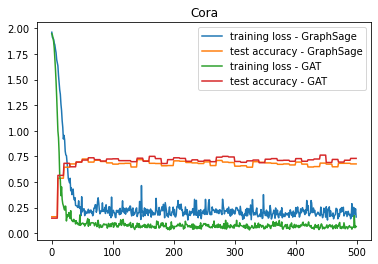

In [8]:
def main():
    for args in [
        {'model_type': 'GraphSage', 'dataset': 'cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 500, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GraphSage', 'GAT']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT': args.heads = 2
            else: args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else: raise NotImplementedError("Unknown dataset") 
            test_accs, losses = train(dataset, args) 

            print("Maximum accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()

# 2 DeepSNAP - основы

В предыдущих блокнотиках мы использовали представления графов в виде классов (NetworkX) и тензоров (PyG) раздельно. Класс `nx.Graph` предоставляет богатый функционал для анализа и манипуляций с графами, таких как вычисления коэффициента кластеризации и PageRank. Для того, чтобы передать граф в модель, нам нужно преобразовать его в тензорное представление, включающее тензор рёбер `edge_index` и тензоры аттрибутов вершин `x` и `y`. Однако использование одних только тензоров (как графы в PyG `datasets` и `data`) делает многие манипуляции с графами и их анализ менее эффективными, а также сложными. В этом блокнотике мы используем DeepSNAP, который совмещает оба представления и предлагает полный функционал для обучения, валидации и тестирования графовых нейронных сетей.


В общем, [DeepSNAP](https://github.com/snap-stanford/deepsnap) - это библиотека для Python, помогающая эффективному глубокому обучению на графах. DeepSNAP включает поддержку разнообразных манипуляций с графами, стандартный поток операций обработки (pipeline), работу с гетерогенными графами и простой API.

1. DeepSNAP легко использовать для уточённых манипуляций с графами, таких как вычисление признаков, предобучение, экстракция субграфов и т.д. во время/до обучения.
2. В большинстве фреймворков стандартные потоки операций для задач на уровне вершин, рёбер (ориентированных и не-), графов в индуктивных или трансдуктивных сценариях - оставлены за рамками функционала и пользователям приходится их реализовывать самостоятельно. На приктике это включает дизайнерские решения (такие как метод разбиения выборки для задачи предсказания связи). DeepSNAP предоставляет стандартный поток операций, который здорово сохраняет усилия и позволяет честное сравнение моделей.
3. Многие графы в реальном мире - гетерогенные. Однако наблюдается дефицит пакетов для гетерогенных графов, включая хранение данных и гибкую передачу сообщений. DeepSNAP предоставляет эффективные и гибкие гетерогенные графы, которые поддерживают гетерогенность вершин и рёбер.

[DeepSNAP](https://github.com/snap-stanford/deepsnap) - это недавно выпущенный проект и он всё ещё в разработке. Если вы столкнётесь с багами или же если у вас есть предложения по улучшению, поднимайте issues или создавайте pull request непосредственно в репозитории на GitHub :)

В этом блокнотике мы сосредоточимся на манипуляции с графами в DeepSNAP и настройках разбиения выборок.

## Установка

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

def visualize(G, color_map=None, seed=123):
  if color_map is None:
    color_map = '#c92506'
  plt.figure(figsize=(8, 8))
  nodes = nx.draw_networkx_nodes(G, pos=nx.spring_layout(G, seed=seed), \
                                 label=None, node_color=color_map, node_shape='o', node_size=150)
  edges = nx.draw_networkx_edges(G, pos=nx.spring_layout(G, seed=seed), alpha=0.5)
  if color_map is not None:
    plt.scatter([],[], c='#c92506', label='Nodes with label 0', edgecolors="black", s=140)
    plt.scatter([],[], c='#fcec00', label='Nodes with label 1', edgecolors="black", s=140)
    plt.legend(prop={'size': 13}, handletextpad=0)
  nodes.set_edgecolor('black')
  plt.show()

## DeepSNAP Graph

Класс `deepsnap.graph.Graph` - самое сердце DeepSNAP. В нём граф не только хранится в тензорном формате, но и ссылается на графовый объект в пакете для манипуляций с графами.

В данный момент DeepSNAP поддерживает [NetworkX](https://networkx.org/) и [Snap.py](https://snap.stanford.edu/snappy/doc/index.html) в качестве движка для операций на графах.

В этом блокнотике мы будем использовать NetworkX.

Попробуем для начала конвертировать простой случайный граф NetworkX в граф DeepSNAP.

In [ ]:
num_nodes = 100
p = 0.05
seed = 100

# Пусть G - случайный граф networkx (модели Эрдоша-Реньи)
G = nx.gnp_random_graph(num_nodes, p, seed=seed)

# Сгенерируем какие-то случайные признаки и метки классов для вершин
node_feature = {node : torch.rand([5, ]) for node in G.nodes()}
node_label = {node : torch.randint(0, 2, ()) for node in G.nodes()}

# Присвоим сгенерированные выше признаки и метки графу G
nx.set_node_attributes(G, node_feature, name='node_feature')
nx.set_node_attributes(G, node_label, name='node_label')

# Посмотрим на одну из вершин
for node in G.nodes(data=True):
  print(node)
  break

color_map = ['#c92506' if node[1]['node_label'].item() == 0 else '#fcec00' for node in G.nodes(data=True)]

# Визуализируем граф
visualize(G, color_map=color_map)

# Трансформируем граф networkx в граф deepsnap
graph = Graph(G)

# Выведем общую информацию о графе deepsnap
print(graph)

# DeepSNAP конвертирует аттрибуты вершин в тензоры
# Обратите внимание на тип тензоров
print("Node feature (node_feature) has shape {} and type {}".format(graph.node_feature.shape, graph.node_feature.dtype))
print("Node label (node_label) has shape {} and type {}".format(graph.node_label.shape, graph.node_label.dtype))

# DeepSNAP также сгенерирует тензор edge_index
print("Edge index (edge_index) has shape {} and type {}".format(graph.edge_index.shape, graph.edge_index.dtype))

# В отличие от простого хранения тензоров, граф deepsnap также ссылается на граф networkx
# Мы обсудим почему ссылка будет полезна чуть позже
print("The DeepSNAP graph has {} as the internal manupulation graph".format(type(graph.G)))

В DeepSNAP доступны аттрибуты трёх уровней. В этом примере у нас есть аттрибуты **уровня вершин**, включающие `node_feature` и `node_label`. Оставшиеся два уровня аттрибутов - относятся к графам и рёбрам. Использование подобно таковому для уровня вершин за исключением того, что признаки становятся `edge_feature` или `graph_feature` и метка класса становится `edge_label` или `graph_label` и т.д.

Подобно графу NetworkX, мы можем получить базовые свойства графа непосредственно через свойства класса.

In [ ]:
# Количество вершин
print("The random graph has {} nodes".format(graph.num_nodes))

# Количество рёбер
print("The random graph has {} edges".format(graph.num_edges))

DeepSNAP также предоставляет функционал, позволяющий автоматически преобразовывать наборы данных PyG в списки графов DeepSNAP.

Здесь мы преобразуем набор данных CORA в список графов DeepSNAP.

In [ ]:
root = './tmp/cora'
name = 'Cora'

# Набор данных Cora
pyg_dataset= Planetoid(root, name)

# Преобразуем набор данных PyG в сприсок графов deepsnap
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Получим первый граф deepsnap (CORA содержит лишь один граф)
graph = graphs[0]
print(graph)

## Вопрос 2.1: Чему равно количество классов и количество признаков в графе CORA? (5 баллов)

Submit your answers on Gradescope.

In [ ]:
def get_num_node_classes(graph):
  # ЗАДАЧА: Реализуйте функцию, принимающую объект графа deepsnap
  # и возвращающую количество классов вершин для этого графа.

  num_node_classes = 0

  ############# Ваш код здесь ##############
  ## (~1 строчка кода)
  ## Обратите внимание
  ## (1) Вам может пригодиться функционал автодополнения Colab
  ## (2) Также может пригодиться документация DeepSNAP https://snap.stanford.edu/deepsnap/modules/graph.html


  ##########################################

  return num_node_classes

def get_num_node_features(graph):
  # ЗАДАЧА: Реализуйте функцию, принимающую объект графа deepsnap
  # и возвращающую количество признаков вершин для этого графа.

  num_node_features = 0

  ############# Ваш код здесь ##############
  ## (~1 строчка кода)
  ## Обратите внимание
  ## (1) Вам может пригодиться функционал автодополнения Colab
  ## (2) Также может пригодиться документация DeepSNAP https://snap.stanford.edu/deepsnap/modules/graph.html


  ##########################################

  return num_node_features

num_node_classes = get_num_node_classes(graph)
num_node_features = get_num_node_features(graph)
print("{} has {} classes".format(name, num_node_classes))
print("{} has {} features".format(name, num_node_features))

## DeepSNAP Dataset

Теперь поговорим о наборах данных в DeepSNAP. Всякий `deepsnap.dataset.GraphDataset` содержит список `deepsnap.graph.Graph` объектов. В дополнение к списку графов, вы также можете определить, для какой задачи предназначен набор данных, таких как задачи уровня вершин (`task=node`), задачи уровня рёбер (`task=link_pred`) и задачи уровня графа (`task=graph`).

Он также содержит много прочих полезных параметров инициализации и прочий функционал. Чтобы узнать больше, обратитесь к [документации](https://snap.stanford.edu/deepsnap/modules/dataset.html#deepsnap-graphdataset).

Теперь воспользуемся набором данных COX2, содержащим список графов и определим задачу как `graph` во время инициализации набора данных DeepSNAP.

In [ ]:
root = './tmp/cox2'
name = 'COX2'

# Загрузим набор данных посредством PyG
pyg_dataset = TUDataset(root, name)

# Конвертируем в список графов deepsnap
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Конвертируем список графов deepsnap в набор данных deepsnap для задачи task=graph
dataset = GraphDataset(graphs, task='graph')
print(dataset)

## Вопрос 2.2.: Какова метка графа (номер 100 в наборе данных COX2)? (5 баллов)

Submit your answers on Gradescope.

In [ ]:
def get_graph_class(dataset, idx):
  # ЗАДАЧА: Реализуйте функцию, принимающую объект набора данных deepsnap, а также
  # индекс графа в наборе данных и возвращающую класс/метку (class/label) 
  # этого графа (как целое число).

  label = -1

  ############# Ваш код здесь ##############
  ## (~1 строчка кода)
  ## Обратите внимание
  ## 1. Метка относится к аттрибутам уровня графа


  #########################################

  return label

graph_0 = dataset[0]
print(graph_0)
idx = 100
label = get_graph_class(dataset, idx)
print('Graph with index {} has label {}'.format(idx, label))

## Вопрос 2.3: Чему равно количество вершин графа (номер 200 в наборе данных COX2)? (5 баллов)

Submit your answers on Gradescope.

In [ ]:
def get_graph_num_edges(dataset, idx):
  # ЗАДАЧА: Реализуйте функцию, принимающую объект набора данных deepsnap, а также
  # индекс графа в наборе данных и возвращающую количество
  # рёбер в этом графе (как целое число).

  num_edges = 0

  ############# Ваш код здесь ##############
  ## (~1 строчка кода)
  ## Обратите внимание
  ## 1. Вы можетет непосредственно использовать свойство класса


  #########################################

  return num_edges

idx = 200
num_edges = get_graph_num_edges(dataset, idx)
print('Graph with index {} has {} edges'.format(idx, num_edges))

# 3 DeepSNAP Advanced

Мы ознакомились с базовыми функциями графов и наборов данных DeepSNAP :)

Приступим же к более продвинутому функционалу.

В данной секции мы воспользуемся DeepSNAP для вычисления признаков и трансдуктивного/индуктивного разбиения выборки для обучения.

## Установка

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

## Разбиение данных в графах

Подготовка выборок для обучение и валидации в случае с графами может быть намного сложнее, чем в областях компьютерного зрения или обрработки естественного языка.

В общем, можно выделить два сценария разбиения данных - **индуктивный** и **трансдуктивный**.

## Индуктивное разбиение

Как говорилось в лекции (НАЙТИ БЫ КОНКРЕТНУЮ ССЫЛКУ), индуктивный сценарий будет разбивать множество графов на обучающую/валидационные части. 

Вот пример индуктивного разбиения в DeepSNAP для списка графов в задаче уровня графа (классификация графов и т.п.)

In [ ]:
root = './tmp/cox2'
name = 'COX2'

pyg_dataset = TUDataset(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Здесь мы определяем задачу как задачу уровня графа, например, классификции графов
task = 'graph'
dataset = GraphDataset(graphs, task=task)

# Зададим transductive=False (inductive)
dataset_train, dataset_val, dataset_test = dataset.split(transductive=False, split_ratio=[0.8, 0.1, 0.1])

print("COX2 train dataset: {}".format(dataset_train))
print("COX2 validation dataset: {}".format(dataset_val))
print("COX2 test dataset: {}".format(dataset_test))

## Трансдуктивное разбиение

В трансдуктивном сценарии обучающая/валидационная выборки определяются на одном и том же графе.

Здесь мы трансдуктивно разделим граф CORA для задач уровня вершин.

(Обратите внимание: по умолчанию DeepSnap настроен разбивать выборки случайным образом, но вы также можете зафиксировать выборки, установив `fixed_split=True` во время загрузки набора данных из PyG или непосредственно изменив `node_label_index`).

In [ ]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Здесь мы определим задачу как задачу уровня вершин, например, классификации вершин
task = 'node'

dataset = GraphDataset(graphs, task=task)

# Укажем, что мы хотим произвести трансдуктивное разбиение
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

print("Original Cora has {} nodes".format(dataset.num_nodes[0]))

# Вершины, оказавшиеся в каждой выборке, можно найти в node_label_index
print("After the split, Cora has {} training nodes".format(dataset_train[0].node_label_index.shape[0]))
print("After the split, Cora has {} validation nodes".format(dataset_val[0].node_label_index.shape[0]))
print("After the split, Cora has {} test nodes".format(dataset_test[0].node_label_index.shape[0]))

## Разбиение на уровне рёбер

По сравнению с разбиением на уровне вершин и графов, разделение на уровне рёбер не так уж и тривиально ;)

Обыкновенно в разбиении данных на уровне рёбер, нам требуется подготовить выборку негативных (отсутствующих) рёбер, разбить позитивные (существующие) рёбра в различные выборки (обучающая/валидационная/тестовая), разбить рёбра в обучающей выборке на передающие сообщения и supervision edges, а также проводить resample для негативных рёбер и т.п.

### All Mode

Начнём с простого разбиения на уровне рёбер, режимом `edge_train_mode="all"` в DeepSNAP.

In [ ]:
root = './tmp/cora'
name = 'Cora'

pyg_dataset = Planetoid(root, name)

graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

# Определим задачу как link_pred задачи уровня рёбер
task = 'link_pred'

# Определим режим обучения, "all" - является стандартным для набора данных deepsnap
edge_train_mode = "all"

dataset = GraphDataset(graphs, task=task, edge_train_mode=edge_train_mode)

# Трансдуктивное разбиение для link prediction
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

print("Cora train dataset: {}".format(dataset_train))
print("Cora validation dataset: {}".format(dataset_val))
print("Cora test dataset: {}".format(dataset_test))

В DeepSNAP, индексы для supervision edges хранятся в тензоре `edge_label_index` и соответствующие метки рёбер хранятся в тензоре `edge_label`.

In [ ]:
print("Original Cora graph has {} edges".format(dataset[0].num_edges))
print("Because Cora graph is undirected, the original edge_index has shape {}".format(dataset[0].edge_index.shape))

print("The training set has message passing edge index shape {}".format(dataset_train[0].edge_index.shape))
print("The training set has supervision edge index shape {}".format(dataset_train[0].edge_label_index.shape))

print("The validation set has message passing edge index shape {}".format(dataset_val[0].edge_index.shape))
print("The validation set has supervision edge index shape {}".format(dataset_val[0].edge_label_index.shape))

print("The test set has message passing edge index shape {}".format(dataset_test[0].edge_index.shape))
print("The test set has supervision edge index shape {}".format(dataset_test[0].edge_label_index.shape))

Как видим, в обучающей и валидационной выборках - одни и те же рёбра для передачи сообщений (message passing edges) (`edge_index`) в режиме `all`. Также, в обучающей выборке, позитивные supervision edges (`edge_label_index`) совпадают с рёбрами для передачи сообщений. Однако, в тестовой выборке рёбра для передачи сообщений являются комбинацией рёбер для передачи сообщений из обучающей и валидационных выборок.

Обратите внимание, что`edge_label` и `edge_label_index` включают негативные рёбра (по умолчанию количество отсутствующих рёбер идентично количеству позитивных рёбер).

Теперь реализуем функцию, которая проверяет, являются ли два тензора индоксов рёбер непересекающимися(disjoint) и исследуем больше свойств разбиения рёбер, используя эту функцию.

## Вопросы 3.1 - 3.5: Реализуйте функцию, проверяющую, являются ли два тензора edge_index непересекающимися (disjoint). Затем подтвердите либо опровергните утверждения ниже. (5 баллов)

Submit your answers on Gradescope.

In [ ]:
def edge_indices_disjoint(edge_index_1, edge_index_2):
  # ЗАДАЧА: Реализуйте функцию, принимающую два тензора индексов рёбер 
  # и возвращающую суждение о том, являются ли эти тензоры непересекающимися множествами.
  # 
  #TODO: Implement this function that takes two edge index tensors,
  # and returns whether these two edge index tensors are disjoint.
  disjoint = None

  ############# Ваш код здесь ##############
  ## (~5 строчек кода)
  ## Обратите внимание:
  ## (1) Здесь под непересекающимися множествами подразумевается что ни одно ребро не принадлежит обоим тензорам
  ## (2) Вам не нужно рассматривать случай неориентированного графа. Например, если edge_index_1 содержит
  ##     ребро (a, b) и edge_index_2 содержит ребро (b, a). В данной функции мы будем рассматривать
  ##     как непересекающиеся множества.
  ##
  ## 1. Here disjoint means that there is no single edge belongs to either edge index tensors
  ## 2. You do not need to consider the undirected case. For example, if edge_index_1 contains
  ## edge (a, b) and edge_index_2 contains edge (b, a). We will treat them as disjoint in this
  ## function.


  #########################################

  return disjoint

In [ ]:
num_train_edges = dataset_train[0].edge_label_index.shape[1] // 2
train_pos_edge_index = dataset_train[0].edge_label_index[:, :num_train_edges]
train_neg_edge_index = dataset_train[0].edge_label_index[:, num_train_edges:]
print("3.1 Training (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(train_pos_edge_index, train_neg_edge_index)))

num_val_edges = dataset_val[0].edge_label_index.shape[1] // 2
val_pos_edge_index = dataset_val[0].edge_label_index[:, :num_val_edges]
val_neg_edge_index = dataset_val[0].edge_label_index[:, num_val_edges:]
print("3.2 Validation (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(val_pos_edge_index, val_neg_edge_index)))

num_test_edges = dataset_test[0].edge_label_index.shape[1] // 2
test_pos_edge_index = dataset_test[0].edge_label_index[:, :num_test_edges]
test_neg_edge_index = dataset_test[0].edge_label_index[:, num_test_edges:]
print("3.3 Test (supervision) positve and negative edges are disjoint = {}"\
        .format(edge_indices_disjoint(test_pos_edge_index, test_neg_edge_index)))

print("3.4 Test (supervision) positve and validation (supervision) positve edges are disjoint = {}"\
        .format(edge_indices_disjoint(test_pos_edge_index, val_pos_edge_index)))
print("3.5 Validation (supervision) positve and training (supervision) positve edges are disjoint = {}"\
        .format(edge_indices_disjoint(val_pos_edge_index, train_pos_edge_index)))

### Disjoint Mode

Теперь посмотрим на относительно более сложный режим трансдуктивного разбиения рёбер, то есть режим `edge_train_mode="disjoint"` в DeepSNAP (также трансдуктивное разбиение для link prediction обсуждалось в лекции - ХОРОШО БЫ НАЙТИ ТОЧНУЮ ССЫЛКУ)

In [ ]:
edge_train_mode = "disjoint"

dataset = GraphDataset(graphs, task='link_pred', edge_train_mode=edge_train_mode)
orig_edge_index = dataset[0].edge_index
dataset_train, dataset_val, dataset_test = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])

train_message_edge_index = dataset_train[0].edge_index
train_sup_edge_index = dataset_train[0].edge_label_index
val_sup_edge_index = dataset_val[0].edge_label_index
test_sup_edge_index = dataset_test[0].edge_label_index

print("The edge index of original graph has shape: {}".format(orig_edge_index.shape))
print("The edge index of training message edges has shape: {}".format(train_message_edge_index.shape))
print("The edge index of training supervision edges has shape: {}".format(train_sup_edge_index.shape))
print("The edge index of validation message edges has shape: {}".format(dataset_val[0].edge_index.shape))
print("The edge index of validation supervision edges has shape: {}".format(val_sup_edge_index.shape))
print("The edge index of test message edges has shape: {}".format(dataset_test[0].edge_index.shape))
print("The edge index of test supervision edges has shape: {}".format(test_sup_edge_index.shape))

You can see that the training / validation message passing edges and training supervision edges are splitted differently in those two modes!

### Resample Negative Edges

Во время каждой итерации обучения нам обычно требуется ресемплинг негативных рёбер.

Ниже мы посмотрим на обучающие и валидационные наборы рёбер для двух итераций обучения.

Вы должны обнаружить, что негативные рёбра в обучающей выборке будут изменяться.

In [ ]:
dataset = GraphDataset(graphs, task='link_pred', edge_train_mode="disjoint")
datasets = {}
follow_batch = []
datasets['train'], datasets['val'], datasets['test'] = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1])
dataloaders = {
  split: DataLoader(
    ds, collate_fn=Batch.collate(follow_batch),
    batch_size=1, shuffle=(split=='train')
  )
  for split, ds in datasets.items()
}
neg_edges_1 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  print("First iteration training negative edges:")
  print(neg_edges_1)
  break
neg_edges_2 = None
for batch in dataloaders['train']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  print("Second iteration training negative edges:")
  print(neg_edges_2)
  break

neg_edges_1 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_1 = batch.edge_label_index[:, num_edges:]
  print("First iteration validation negative edges:")
  print(neg_edges_1)
  break
neg_edges_2 = None
for batch in dataloaders['val']:
  num_edges = batch.edge_label_index.shape[1] // 2
  neg_edges_2 = batch.edge_label_index[:, num_edges:]
  print("Second iteration validation negative edges:")
  print(neg_edges_2)
  break

Если вас интересуют настройки разбиения графов, обратитесь к [документации](https://snap.stanford.edu/deepsnap/modules/dataset.html) по работе с наборами данных в DeepSNAP.

## Трансформации графов и вычисление признаков

Ещё одна ключевая функциональность DeepSNAP - это трансформации графов и вычисление признаков.

В DeepSNAP мы разделяем трансформацию графов / вычисление признаков в два различных типа. Первый - трансформация до обучения (изменяющая весь набор данных непосредственно перед обучением) и второй - трансформация во время обучения (изменяющая партии (batches) графов).

Вот пример, который использует NetworkX для вычисления значений PageRank и обновляет значения в тензорах перед обучением (трансформация набора данных).

In [ ]:
def pagerank_transform_fn(graph):

  # Получим входной граф / Get the referenced networkx graph
  G = graph.G

  # Вычислим значения PageRank в NetworkX / Calculate the pagerank by using networkx
  pr = nx.pagerank(G)

  # Трансформируем полученные значения PageRank в тензор
  pr_feature = torch.tensor([pr[node] for node in range(graph.num_nodes)], dtype=torch.float32)
  pr_feature = pr_feature.view(graph.num_nodes, 1)

  # Конкатенируем значения PageRank с признаками вершин
  graph.node_feature = torch.cat([graph.node_feature, pr_feature], dim=-1)

root = './tmp/cox2'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')
print("Number of features before transformation: {}".format(dataset.num_node_features))
dataset.apply_transform(pagerank_transform_fn, update_tensor=False)
print("Number of features after transformation: {}".format(dataset.num_node_features))

## Вопрос 3.6: Реализуйте трансформацию ниже и сообщите коэффициент кластеризации для вершины (номер 3) графа (номер 406) в наборе данных COX2. Округлите ответ до двух десятичных знаков. (5 баллов)

In [ ]:
def cluster_transform_fn(graph):
  # ЗАДАЧА: Реализуйте функцию, принимающую объект графа deepsnap и
  # трансформирующую граф путём добавления коэффициента кластеризации
  # в graph.node_feature
  #
  #TODO: Implement this function that takes an deepsnap graph object,
  # transform the graph by adding nodes clustering coefficient into the 
  # graph.node_feature

  ############# Ваш код здесь ##############
  ## (~5 строчек кода)
  ## Обратите внимание:
  ## (1) Вычислите коэффициент кластеризации для каждой вершины и 
  ## конкатенируйте полученные значения справа с вектором признаков
  ## (to the last dimension of graph.node_feature)


  #########################################

root = './cox2'
name = 'COX2'
pyg_dataset = TUDataset(root, name)
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task='graph')

# Трансформируем набор данных
dataset.apply_transform(cluster_transform_fn, update_tensor=False)

node_idx = 3
graph_idx = 406
node_feature = dataset[graph_idx].node_feature

print("The node has clustering coefficient: {}".format(round(node_feature[node_idx][-1].item(), 2)))

Кроме трансформации набора данных, DeepSNAP также может трансформировать граф (обыкновенно `deepsnap.batch.Batch`) во время каждой итерации обучения.

Также DeepSNAP поддерживает синхронизацию трансформации между связанными объектами графов и их тензорными представлениями. Например, вы можете просто обновить граф в NetworkX в трансформирующей функции и, задав `update_tensor=True`, автоматически обновить тензорные представления.

За более подробной информацией, пожалуйста обращайтесь к [документации](https://snap.stanford.edu/deepsnap/) DeepSNAP.

# 4 Edge Level Prediction

Из предыдущей секции мы знаем каким образом DeepSNAP производит трансдуктивное разбиение рёбер для задачи предсказания связи (link prediction).

Теперь используем DeepSNAP и PyG вместе для реализации задачи предсказания на уровне рёбер (link prediction)!

In [ ]:
import copy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset

from torch.utils.data import DataLoader

import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class LinkPredModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout=0.2):
        super(LinkPredModel, self).__init__()

        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, num_classes)

        self.loss_fn = None

        ############# Ваш код здесь ##############
        ## (~1 строчка кода)
        ## Обратите внимание:
        ## (1) Инициализируйте функцию потерь как BCEWithLogitsLoss


        ##########################################

        self.dropout = dropout

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, batch):
        node_feature, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        
        ############# Ваш код здесь ##############
        ## (~6 строчек кода)
        ## Обратите внимание:
        ## (1) Отправьте признаки вершин в первый слой свёртки (conv layer)
        ## (2) Добавьте ReLU после слоя свёртки
        ## (3) Добавьте dropout после ReLU (с вероятностью self.dropout)
        ## (4) Направьте выход во второй слой свёртки
        ## (5) Выберите эмбеддинги для начальных и конечных вершин,
        ##     используя edge_label_index и вычислите подобие каждой пары
        ##     как скалярное произведение
        ##
        ##
        ##
        ## 1. Feed the node feature into the first conv layer
        ## 2. Add a ReLU after the first conv layer
        ## 3. Add dropout after the ReLU (with probability self.dropout)
        ## 4. Feed the output to the second conv layer
        ## 5. Select the embeddings of the source nodes and destination nodes
        ## by using the edge_label_index and compute the similarity of each pair
        ## by dot product

        
        ##########################################

        return pred
    
    def loss(self, pred, link_label):
        return self.loss_fn(pred, link_label)

In [ ]:
from sklearn.metrics import *

def train(model, dataloaders, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args["epochs"]):
        for i, batch in enumerate(dataloaders['train']):
            
            batch.to(args["device"])

            ############# Ваш код здесь ##############
            ## (~6 строчек кода)
            ## Обратите внимание:
            ## (1) Обнулите градиенты оптимизатора
            ## (2) Вычислите функцию потерь и проведите обратное распространение
            ## (3) Обновите параметры модели
            ##
            ## 1. Zero grad the optimizer
            ## 2. Compute loss and backpropagate
            ## 3. Update the model parameters


            ##########################################

            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {}'
            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)

            print(log.format(epoch, score_train, score_val, score_test, loss.item()))
            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)
    return best_model

def test(model, dataloader, args):
    model.eval()

    score = 0

    ############# Ваш код здесь ##############
    ## (~6 строчек кода)
    ## Обратите внимание:
    ## (1) Итерируйте по партиям в загрузчике данных
    ## (2) Загрузите партию в модель
    ## (3) Направьте выход модели в сигмоид
    ## (4) Вычислите ROC-AUC score, используя функцию sklearn roc_auc_score
    ## (5) Метки рёбер хранятся в batch.edge_label
    ##
    ## 1. Loop through batches in the dataloader
    ## 2. Feed the batch to the model
    ## 3. Feed the model output to sigmoid
    ## 4. Compute the ROC-AUC score by using sklearn roc_auc_score function
    ## 5. Edge labels are stored in batch.edge_label

    
    ##########################################
 
    return score

In [ ]:
# Пожалуйста не изменяйте параметры
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_dim" : 128,
    "epochs" : 200,
}

In [ ]:
pyg_dataset = Planetoid('./tmp/cora', 'Cora')
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)

dataset = GraphDataset(
        graphs,
        task='link_pred',
        edge_train_mode="disjoint"
    )
datasets = {}
datasets['train'], datasets['val'], datasets['test']= dataset.split(
            transductive=True, split_ratio=[0.85, 0.05, 0.1])
input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

model = LinkPredModel(input_dim, args["hidden_dim"], num_classes).to(args["device"])
model.reset_parameters()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

dataloaders = {split: DataLoader(
            ds, collate_fn=Batch.collate([]),
            batch_size=1, shuffle=(split=='train'))
            for split, ds in datasets.items()}
best_model = train(model, dataloaders, optimizer, args)
log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)
print(log.format(best_train_roc, best_val_roc, best_test_roc))

## Вопрос 4: Каково максимальное значение ROC-AUC score для best_model на тесте? (13 баллов)

Submit your answers on Gradescope.

# Submission

In order to get credit, you must go submit your answers on Gradescope.

Also, you need to submit the `ipynb` file of Colab 3, by clicking `File` and `Download .ipynb`. Please make sure that your output of each cell is available in your `ipynb` file.